In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  NVIDIA GeForce RTX 4090


In [3]:
class Attention(nn.Module):
    '''
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :-
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key   = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key   = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) | Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)

        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [4]:
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    '''
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    '''
    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [5]:
class TransformerBlock(nn.Module):
    '''
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-

    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res

        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out

In [6]:
class Transformer(nn.Module):
    '''
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    '''
    def __init__(self, embed_dim, layers, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout) for i in range(layers)]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [7]:
# Not Exactly Same as Paper
class ClassificationHead(nn.Module):
    '''
    Classification Head attached to the first sequence token which is used as the arbitrary
    classification token and used to optimize the transformer model by applying Cross-Entropy
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    '''
    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes)
        return out

In [8]:
class VisionTransformer(nn.Module):
    '''
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|

    Args:
        patch_size: Length of square patch size
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)

    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    '''
    def __init__(self, patch_size, max_len, embed_dim, classes, layers, channels=3, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.name = 'VisionTransformer'
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        out = inp.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).contiguous()
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) | seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()

        out = out.reshape(batch_size, seq_len, -1)
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[:seq_len+1]
        position_embed = position_embed.unsqueeze(0).expand(batch_size, seq_len+1, self.embed_dim)
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim)
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)

        return class_out, out

In [9]:
# Initializations of all the constants used in the training and testing process

lr = 0.003
batch_size = 128
num_workers = 2
shuffle = True
patch_size = 4
image_sz = 32
max_len = 65 # All sequences must be less than 1000 including class token
embed_dim = 128
classes = 10
layers = 6
channels = 3
heads = 8
epochs = 100

In [10]:
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        ),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        ),
    ]
)


trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

In [11]:
# del model
torch.cuda.empty_cache()

In [12]:
model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads)
model

VisionTransformer(
  (patch_to_embed): Linear(in_features=48, out_features=128, bias=True)
  (transformer): Transformer(
    (trans_blocks): ModuleList(
      (0-5): 6 x TransformerBlock(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attention): Attention(
          (query): Linear(in_features=128, out_features=128, bias=True)
          (key): Linear(in_features=128, out_features=128, bias=True)
          (value): Linear(in_features=128, out_features=128, bias=True)
          (softmax): Softmax(dim=-1)
          (activation): Identity()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (feed_forward): FeedForward(
          (fc1): Linear(in_features=128, out_features=128, bias=True)
          (activation): GELU(approximate='none')
          (fc2): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
    

In [13]:
model = model.to(device)
from torch.amp import GradScaler
model.no_custom_backward = False
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(trainloader), epochs=epochs)
scaler = GradScaler()

In [14]:
# Get model parameter count
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params:,}")

Total Parameters: 522,058


In [15]:
# Estimate model size (assuming float32 parameters, 4 bytes each)
model_size_mb = (total_params * 4) / (1024 * 1024)
print(f"Model Size: {model_size_mb:.2f} MB")

Model Size: 1.99 MB


In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
# Training without saving
from tqdm import tqdm
def train(epoch):
    print("\nTraining Epoch: %d" % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
        # We do not need to specify AMP autocast in forward pass here since
        # that is taken care of already in the forward of individual modules.
        inputs, targets = inputs.to(device), targets.to(device)
        outputs,_ = model(inputs)
        # print(outputs)
        loss = criterion(outputs, targets)

        # standard pytorch AMP training setup
        # scaler also works without amp training.
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(f"Training Accuracy:{100.*correct/total: 0.2f}")
    print(f"Training Loss:{train_loss/(batch_idx+1): 0.3f}")
    return 100.0 * correct / total, train_loss / (batch_idx + 1)


def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    print("\nTesting Epoch: %d" % epoch)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs,_ = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print(f"Test Accuracy:{100.*correct/total: 0.2f}")
        print(f"Test Loss:{test_loss/(batch_idx+1): 0.3f}")
        return 100.0 * correct / total, test_loss / (batch_idx + 1)

In [18]:
import random

import numpy as np

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [20]:
# from thop import profile
# dummy_input = torch.randn(1, 3, 32, 32).to(device)
# flops, _ = profile(model, inputs=(dummy_input,), verbose=False)
# print(f"FLOPs per inference step: {flops / 1e9:.2f} GFLOPs")

In [23]:
import os
save_dir = './baseline_vit_checkpoint'

In [24]:
import time

In [24]:
import time
train_accs = []
test_accs = []

# Set up CUDA memory tracking
torch.cuda.reset_peak_memory_stats(device)  # Reset memory tracking
start_time = time.time()
for epoch in range(epochs):
    epoch_start = time.time()
    # Track peak memory usage
    torch.cuda.memory_allocated(device)  # Ensure PyTorch updates memory usage tracking
    torch.cuda.reset_peak_memory_stats(device)
    
    train_acc, train_loss = train(epoch)
    test_acc, test_loss = test(epoch)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    epoch_time = time.time() - epoch_start
    print(f"Time taken for epoch {epoch+1}: {epoch_time:.2f} seconds")
    # Track peak GPU memory usage
    peak_memory = torch.cuda.max_memory_allocated(device) / (1024**3)  # Convert to GB
    print(f"Peak GPU memory usage: {peak_memory:.2f} GB")
    
    # TFLOPs estimation for each epoch
    input_resolution = 32  # CIFAR-10 image size
    flops_per_image = (2 * total_params * input_resolution * input_resolution) / 1e12  # Approx. FLOPs per image
    total_tflops = flops_per_image * len(trainloader.dataset)  # TFLOPs per epoch
    print(f"Estimated TFLOPs for epoch {epoch+1}: {total_tflops:.4f}")
    
    if (epoch+1)%5 == 0:
        checkpoint_path = os.path.join(save_dir, f"VIT_CIFAR10_checkpoint_epoch_{epoch+1}.pt")
        torch.save({
            'epoch': epoch+1,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'train_acc': train_accs,
            'test_acc': test_accs
        }, checkpoint_path)
        
# End timing after training
total_training_time = time.time() - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

# Save final model checkpoint
final_checkpoint_path =  os.path.join(save_dir, f"VIT_CIFAR10_checkpoint_epoch_final.pt")
torch.save({
    'epoch': epochs,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'train_acc': train_accs,
    'test_acc': test_accs
}, final_checkpoint_path)

print(f"Final model saved at: {final_checkpoint_path}")



Training Epoch: 0


100%|██████████| 391/391 [00:12<00:00, 30.76it/s]


Training Accuracy: 28.15
Training Loss: 1.936

Testing Epoch: 0


100%|██████████| 79/79 [00:01<00:00, 69.80it/s]


Test Accuracy: 39.64
Test Loss: 1.670
Time taken for epoch 1: 13.86 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 1: 53.4587

Training Epoch: 1


100%|██████████| 391/391 [00:12<00:00, 31.37it/s]


Training Accuracy: 38.93
Training Loss: 1.666

Testing Epoch: 1


100%|██████████| 79/79 [00:01<00:00, 68.95it/s]


Test Accuracy: 46.89
Test Loss: 1.476
Time taken for epoch 2: 13.61 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 2: 53.4587

Training Epoch: 2


100%|██████████| 391/391 [00:12<00:00, 31.50it/s]


Training Accuracy: 42.87
Training Loss: 1.564

Testing Epoch: 2


100%|██████████| 79/79 [00:01<00:00, 68.44it/s]


Test Accuracy: 49.29
Test Loss: 1.413
Time taken for epoch 3: 13.57 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 3: 53.4587

Training Epoch: 3


100%|██████████| 391/391 [00:12<00:00, 31.83it/s]


Training Accuracy: 45.16
Training Loss: 1.506

Testing Epoch: 3


100%|██████████| 79/79 [00:01<00:00, 63.48it/s]


Test Accuracy: 50.91
Test Loss: 1.366
Time taken for epoch 4: 13.53 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 4: 53.4587

Training Epoch: 4


100%|██████████| 391/391 [00:14<00:00, 27.88it/s]


Training Accuracy: 46.96
Training Loss: 1.459

Testing Epoch: 4


100%|██████████| 79/79 [00:01<00:00, 51.30it/s]


Test Accuracy: 51.99
Test Loss: 1.325
Time taken for epoch 5: 15.57 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 5: 53.4587

Training Epoch: 5


100%|██████████| 391/391 [00:14<00:00, 26.82it/s]


Training Accuracy: 48.28
Training Loss: 1.424

Testing Epoch: 5


100%|██████████| 79/79 [00:01<00:00, 53.71it/s]


Test Accuracy: 53.18
Test Loss: 1.306
Time taken for epoch 6: 16.05 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 6: 53.4587

Training Epoch: 6


100%|██████████| 391/391 [00:14<00:00, 26.55it/s]


Training Accuracy: 49.84
Training Loss: 1.393

Testing Epoch: 6


100%|██████████| 79/79 [00:01<00:00, 61.78it/s]


Test Accuracy: 53.72
Test Loss: 1.291
Time taken for epoch 7: 16.01 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 7: 53.4587

Training Epoch: 7


100%|██████████| 391/391 [00:14<00:00, 26.62it/s]


Training Accuracy: 50.21
Training Loss: 1.371

Testing Epoch: 7


100%|██████████| 79/79 [00:01<00:00, 55.26it/s]


Test Accuracy: 54.99
Test Loss: 1.254
Time taken for epoch 8: 16.12 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 8: 53.4587

Training Epoch: 8


100%|██████████| 391/391 [00:14<00:00, 26.52it/s]


Training Accuracy: 51.28
Training Loss: 1.347

Testing Epoch: 8


100%|██████████| 79/79 [00:01<00:00, 57.15it/s]


Test Accuracy: 55.92
Test Loss: 1.232
Time taken for epoch 9: 16.13 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 9: 53.4587

Training Epoch: 9


100%|██████████| 391/391 [00:14<00:00, 26.90it/s]


Training Accuracy: 52.55
Training Loss: 1.317

Testing Epoch: 9


100%|██████████| 79/79 [00:01<00:00, 56.77it/s]


Test Accuracy: 56.58
Test Loss: 1.211
Time taken for epoch 10: 15.93 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 10: 53.4587

Training Epoch: 10


100%|██████████| 391/391 [00:14<00:00, 26.53it/s]


Training Accuracy: 52.95
Training Loss: 1.298

Testing Epoch: 10


100%|██████████| 79/79 [00:01<00:00, 56.62it/s]


Test Accuracy: 57.16
Test Loss: 1.187
Time taken for epoch 11: 16.14 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 11: 53.4587

Training Epoch: 11


100%|██████████| 391/391 [00:12<00:00, 30.22it/s]


Training Accuracy: 53.67
Training Loss: 1.282

Testing Epoch: 11


100%|██████████| 79/79 [00:01<00:00, 70.38it/s]


Test Accuracy: 57.77
Test Loss: 1.176
Time taken for epoch 12: 14.06 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 12: 53.4587

Training Epoch: 12


100%|██████████| 391/391 [00:12<00:00, 31.43it/s]


Training Accuracy: 54.30
Training Loss: 1.265

Testing Epoch: 12


100%|██████████| 79/79 [00:01<00:00, 70.26it/s]


Test Accuracy: 57.95
Test Loss: 1.168
Time taken for epoch 13: 13.57 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 13: 53.4587

Training Epoch: 13


100%|██████████| 391/391 [00:12<00:00, 31.76it/s]


Training Accuracy: 54.91
Training Loss: 1.249

Testing Epoch: 13


100%|██████████| 79/79 [00:01<00:00, 66.26it/s]


Test Accuracy: 58.82
Test Loss: 1.143
Time taken for epoch 14: 13.50 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 14: 53.4587

Training Epoch: 14


100%|██████████| 391/391 [00:12<00:00, 31.87it/s]


Training Accuracy: 55.38
Training Loss: 1.231

Testing Epoch: 14


100%|██████████| 79/79 [00:01<00:00, 61.98it/s]


Test Accuracy: 58.82
Test Loss: 1.146
Time taken for epoch 15: 13.55 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 15: 53.4587

Training Epoch: 15


100%|██████████| 391/391 [00:11<00:00, 32.59it/s]


Training Accuracy: 56.04
Training Loss: 1.217

Testing Epoch: 15


100%|██████████| 79/79 [00:01<00:00, 60.82it/s]


Test Accuracy: 59.63
Test Loss: 1.136
Time taken for epoch 16: 13.30 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 16: 53.4587

Training Epoch: 16


100%|██████████| 391/391 [00:12<00:00, 32.07it/s]


Training Accuracy: 56.31
Training Loss: 1.212

Testing Epoch: 16


100%|██████████| 79/79 [00:01<00:00, 63.92it/s]


Test Accuracy: 59.56
Test Loss: 1.125
Time taken for epoch 17: 13.43 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 17: 53.4587

Training Epoch: 17


100%|██████████| 391/391 [00:12<00:00, 31.76it/s]


Training Accuracy: 57.08
Training Loss: 1.190

Testing Epoch: 17


100%|██████████| 79/79 [00:01<00:00, 72.49it/s]


Test Accuracy: 59.55
Test Loss: 1.122
Time taken for epoch 18: 13.40 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 18: 53.4587

Training Epoch: 18


100%|██████████| 391/391 [00:12<00:00, 31.39it/s]


Training Accuracy: 57.35
Training Loss: 1.183

Testing Epoch: 18


100%|██████████| 79/79 [00:01<00:00, 75.89it/s]


Test Accuracy: 60.13
Test Loss: 1.093
Time taken for epoch 19: 13.50 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 19: 53.4587

Training Epoch: 19


100%|██████████| 391/391 [00:12<00:00, 31.17it/s]


Training Accuracy: 57.96
Training Loss: 1.171

Testing Epoch: 19


100%|██████████| 79/79 [00:01<00:00, 71.59it/s]


Test Accuracy: 60.42
Test Loss: 1.099
Time taken for epoch 20: 13.65 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 20: 53.4587

Training Epoch: 20


100%|██████████| 391/391 [00:12<00:00, 31.39it/s]


Training Accuracy: 57.92
Training Loss: 1.163

Testing Epoch: 20


100%|██████████| 79/79 [00:01<00:00, 70.53it/s]


Test Accuracy: 61.11
Test Loss: 1.085
Time taken for epoch 21: 13.58 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 21: 53.4587

Training Epoch: 21


100%|██████████| 391/391 [00:11<00:00, 33.07it/s]


Training Accuracy: 58.82
Training Loss: 1.150

Testing Epoch: 21


100%|██████████| 79/79 [00:00<00:00, 112.25it/s]


Test Accuracy: 61.47
Test Loss: 1.072
Time taken for epoch 22: 12.53 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 22: 53.4587

Training Epoch: 22


100%|██████████| 391/391 [00:08<00:00, 47.79it/s]


Training Accuracy: 59.28
Training Loss: 1.135

Testing Epoch: 22


100%|██████████| 79/79 [00:00<00:00, 112.84it/s]


Test Accuracy: 61.67
Test Loss: 1.067
Time taken for epoch 23: 8.89 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 23: 53.4587

Training Epoch: 23


100%|██████████| 391/391 [00:08<00:00, 47.03it/s]


Training Accuracy: 59.42
Training Loss: 1.128

Testing Epoch: 23


100%|██████████| 79/79 [00:00<00:00, 93.33it/s]


Test Accuracy: 61.68
Test Loss: 1.063
Time taken for epoch 24: 9.17 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 24: 53.4587

Training Epoch: 24


100%|██████████| 391/391 [00:08<00:00, 47.15it/s]


Training Accuracy: 59.77
Training Loss: 1.120

Testing Epoch: 24


100%|██████████| 79/79 [00:00<00:00, 110.15it/s]


Test Accuracy: 61.77
Test Loss: 1.053
Time taken for epoch 25: 9.01 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 25: 53.4587

Training Epoch: 25


100%|██████████| 391/391 [00:08<00:00, 47.56it/s]


Training Accuracy: 60.39
Training Loss: 1.106

Testing Epoch: 25


100%|██████████| 79/79 [00:00<00:00, 125.07it/s]


Test Accuracy: 61.96
Test Loss: 1.053
Time taken for epoch 26: 8.86 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 26: 53.4587

Training Epoch: 26


100%|██████████| 391/391 [00:08<00:00, 45.59it/s]


Training Accuracy: 60.68
Training Loss: 1.095

Testing Epoch: 26


100%|██████████| 79/79 [00:00<00:00, 104.81it/s]


Test Accuracy: 63.10
Test Loss: 1.037
Time taken for epoch 27: 9.34 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 27: 53.4587

Training Epoch: 27


100%|██████████| 391/391 [00:08<00:00, 47.62it/s]


Training Accuracy: 61.08
Training Loss: 1.086

Testing Epoch: 27


100%|██████████| 79/79 [00:00<00:00, 114.29it/s]


Test Accuracy: 63.78
Test Loss: 1.022
Time taken for epoch 28: 8.91 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 28: 53.4587

Training Epoch: 28


100%|██████████| 391/391 [00:08<00:00, 48.69it/s]


Training Accuracy: 61.47
Training Loss: 1.080

Testing Epoch: 28


100%|██████████| 79/79 [00:00<00:00, 91.63it/s] 


Test Accuracy: 63.14
Test Loss: 1.015
Time taken for epoch 29: 8.90 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 29: 53.4587

Training Epoch: 29


100%|██████████| 391/391 [00:08<00:00, 46.54it/s]


Training Accuracy: 61.83
Training Loss: 1.073

Testing Epoch: 29


100%|██████████| 79/79 [00:00<00:00, 109.00it/s]


Test Accuracy: 63.36
Test Loss: 1.020
Time taken for epoch 30: 9.13 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 30: 53.4587

Training Epoch: 30


100%|██████████| 391/391 [00:08<00:00, 47.69it/s]


Training Accuracy: 61.69
Training Loss: 1.065

Testing Epoch: 30


100%|██████████| 79/79 [00:00<00:00, 115.67it/s]


Test Accuracy: 64.11
Test Loss: 0.999
Time taken for epoch 31: 8.88 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 31: 53.4587

Training Epoch: 31


100%|██████████| 391/391 [00:08<00:00, 45.15it/s]


Training Accuracy: 62.37
Training Loss: 1.050

Testing Epoch: 31


100%|██████████| 79/79 [00:00<00:00, 107.01it/s]


Test Accuracy: 64.21
Test Loss: 0.995
Time taken for epoch 32: 9.40 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 32: 53.4587

Training Epoch: 32


100%|██████████| 391/391 [00:08<00:00, 48.15it/s]


Training Accuracy: 62.64
Training Loss: 1.047

Testing Epoch: 32


100%|██████████| 79/79 [00:00<00:00, 116.62it/s]


Test Accuracy: 64.14
Test Loss: 0.994
Time taken for epoch 33: 8.80 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 33: 53.4587

Training Epoch: 33


100%|██████████| 391/391 [00:08<00:00, 48.58it/s]


Training Accuracy: 63.07
Training Loss: 1.039

Testing Epoch: 33


100%|██████████| 79/79 [00:00<00:00, 95.14it/s] 


Test Accuracy: 64.63
Test Loss: 0.985
Time taken for epoch 34: 8.88 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 34: 53.4587

Training Epoch: 34


100%|██████████| 391/391 [00:08<00:00, 45.71it/s]


Training Accuracy: 63.39
Training Loss: 1.026

Testing Epoch: 34


100%|██████████| 79/79 [00:00<00:00, 114.40it/s]


Test Accuracy: 64.30
Test Loss: 0.985
Time taken for epoch 35: 9.25 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 35: 53.4587

Training Epoch: 35


100%|██████████| 391/391 [00:08<00:00, 47.55it/s]


Training Accuracy: 63.34
Training Loss: 1.020

Testing Epoch: 35


100%|██████████| 79/79 [00:00<00:00, 114.93it/s]


Test Accuracy: 65.60
Test Loss: 0.968
Time taken for epoch 36: 8.91 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 36: 53.4587

Training Epoch: 36


100%|██████████| 391/391 [00:08<00:00, 46.74it/s]


Training Accuracy: 63.96
Training Loss: 1.011

Testing Epoch: 36


100%|██████████| 79/79 [00:00<00:00, 92.37it/s]


Test Accuracy: 65.12
Test Loss: 0.968
Time taken for epoch 37: 9.22 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 37: 53.4587

Training Epoch: 37


100%|██████████| 391/391 [00:08<00:00, 47.99it/s]


Training Accuracy: 63.98
Training Loss: 1.006

Testing Epoch: 37


100%|██████████| 79/79 [00:00<00:00, 110.19it/s]


Test Accuracy: 65.56
Test Loss: 0.964
Time taken for epoch 38: 8.87 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 38: 53.4587

Training Epoch: 38


100%|██████████| 391/391 [00:08<00:00, 47.63it/s]


Training Accuracy: 64.58
Training Loss: 0.995

Testing Epoch: 38


100%|██████████| 79/79 [00:00<00:00, 93.15it/s] 


Test Accuracy: 65.40
Test Loss: 0.966
Time taken for epoch 39: 9.06 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 39: 53.4587

Training Epoch: 39


100%|██████████| 391/391 [00:08<00:00, 46.09it/s]


Training Accuracy: 64.62
Training Loss: 0.992

Testing Epoch: 39


100%|██████████| 79/79 [00:00<00:00, 118.53it/s]


Test Accuracy: 65.68
Test Loss: 0.960
Time taken for epoch 40: 9.15 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 40: 53.4587

Training Epoch: 40


100%|██████████| 391/391 [00:08<00:00, 47.76it/s]


Training Accuracy: 64.90
Training Loss: 0.982

Testing Epoch: 40


100%|██████████| 79/79 [00:00<00:00, 120.03it/s]


Test Accuracy: 66.10
Test Loss: 0.940
Time taken for epoch 41: 8.85 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 41: 53.4587

Training Epoch: 41


100%|██████████| 391/391 [00:07<00:00, 48.92it/s]


Training Accuracy: 64.82
Training Loss: 0.982

Testing Epoch: 41


100%|██████████| 79/79 [00:00<00:00, 89.68it/s]


Test Accuracy: 65.90
Test Loss: 0.967
Time taken for epoch 42: 8.88 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 42: 53.4587

Training Epoch: 42


100%|██████████| 391/391 [00:08<00:00, 47.09it/s]


Training Accuracy: 65.23
Training Loss: 0.972

Testing Epoch: 42


100%|██████████| 79/79 [00:00<00:00, 110.46it/s]


Test Accuracy: 66.70
Test Loss: 0.938
Time taken for epoch 43: 9.02 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 43: 53.4587

Training Epoch: 43


100%|██████████| 391/391 [00:08<00:00, 46.69it/s]


Training Accuracy: 65.68
Training Loss: 0.965

Testing Epoch: 43


100%|██████████| 79/79 [00:00<00:00, 105.78it/s]


Test Accuracy: 66.51
Test Loss: 0.934
Time taken for epoch 44: 9.12 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 44: 53.4587

Training Epoch: 44


100%|██████████| 391/391 [00:08<00:00, 45.58it/s]


Training Accuracy: 65.70
Training Loss: 0.957

Testing Epoch: 44


100%|██████████| 79/79 [00:00<00:00, 118.80it/s]


Test Accuracy: 66.85
Test Loss: 0.930
Time taken for epoch 45: 9.25 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 45: 53.4587

Training Epoch: 45


100%|██████████| 391/391 [00:08<00:00, 48.17it/s]


Training Accuracy: 66.36
Training Loss: 0.951

Testing Epoch: 45


100%|██████████| 79/79 [00:00<00:00, 115.56it/s]


Test Accuracy: 67.26
Test Loss: 0.912
Time taken for epoch 46: 8.80 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 46: 53.4587

Training Epoch: 46


100%|██████████| 391/391 [00:08<00:00, 47.40it/s]


Training Accuracy: 66.35
Training Loss: 0.947

Testing Epoch: 46


100%|██████████| 79/79 [00:00<00:00, 89.95it/s] 


Test Accuracy: 67.30
Test Loss: 0.922
Time taken for epoch 47: 9.13 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 47: 53.4587

Training Epoch: 47


100%|██████████| 391/391 [00:08<00:00, 46.58it/s]


Training Accuracy: 66.74
Training Loss: 0.934

Testing Epoch: 47


100%|██████████| 79/79 [00:00<00:00, 112.18it/s]


Test Accuracy: 67.60
Test Loss: 0.903
Time taken for epoch 48: 9.10 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 48: 53.4587

Training Epoch: 48


100%|██████████| 391/391 [00:08<00:00, 47.99it/s]


Training Accuracy: 67.06
Training Loss: 0.926

Testing Epoch: 48


100%|██████████| 79/79 [00:00<00:00, 108.63it/s]


Test Accuracy: 68.07
Test Loss: 0.892
Time taken for epoch 49: 8.88 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 49: 53.4587

Training Epoch: 49


100%|██████████| 391/391 [00:08<00:00, 45.66it/s]


Training Accuracy: 67.37
Training Loss: 0.918

Testing Epoch: 49


100%|██████████| 79/79 [00:00<00:00, 102.51it/s]


Test Accuracy: 68.34
Test Loss: 0.899
Time taken for epoch 50: 9.34 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 50: 53.4587

Training Epoch: 50


100%|██████████| 391/391 [00:08<00:00, 48.52it/s]


Training Accuracy: 67.26
Training Loss: 0.918

Testing Epoch: 50


100%|██████████| 79/79 [00:00<00:00, 108.46it/s]


Test Accuracy: 68.47
Test Loss: 0.891
Time taken for epoch 51: 8.79 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 51: 53.4587

Training Epoch: 51


100%|██████████| 391/391 [00:08<00:00, 48.00it/s]


Training Accuracy: 67.37
Training Loss: 0.911

Testing Epoch: 51


100%|██████████| 79/79 [00:00<00:00, 95.56it/s] 


Test Accuracy: 68.69
Test Loss: 0.883
Time taken for epoch 52: 8.97 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 52: 53.4587

Training Epoch: 52


100%|██████████| 391/391 [00:08<00:00, 45.68it/s]


Training Accuracy: 67.72
Training Loss: 0.904

Testing Epoch: 52


100%|██████████| 79/79 [00:00<00:00, 112.64it/s]


Test Accuracy: 69.00
Test Loss: 0.874
Time taken for epoch 53: 9.27 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 53: 53.4587

Training Epoch: 53


100%|██████████| 391/391 [00:08<00:00, 47.69it/s]


Training Accuracy: 67.96
Training Loss: 0.900

Testing Epoch: 53


100%|██████████| 79/79 [00:00<00:00, 122.07it/s]


Test Accuracy: 68.81
Test Loss: 0.876
Time taken for epoch 54: 8.85 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 54: 53.4587

Training Epoch: 54


100%|██████████| 391/391 [00:08<00:00, 47.60it/s]


Training Accuracy: 68.27
Training Loss: 0.891

Testing Epoch: 54


100%|██████████| 79/79 [00:00<00:00, 88.89it/s]


Test Accuracy: 68.60
Test Loss: 0.871
Time taken for epoch 55: 9.11 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 55: 53.4587

Training Epoch: 55


100%|██████████| 391/391 [00:08<00:00, 47.22it/s]


Training Accuracy: 68.48
Training Loss: 0.885

Testing Epoch: 55


100%|██████████| 79/79 [00:00<00:00, 114.89it/s]


Test Accuracy: 69.04
Test Loss: 0.870
Time taken for epoch 56: 8.97 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 56: 53.4587

Training Epoch: 56


100%|██████████| 391/391 [00:08<00:00, 47.30it/s]


Training Accuracy: 68.54
Training Loss: 0.883

Testing Epoch: 56


100%|██████████| 79/79 [00:00<00:00, 118.96it/s]


Test Accuracy: 69.26
Test Loss: 0.862
Time taken for epoch 57: 8.94 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 57: 53.4587

Training Epoch: 57


100%|██████████| 391/391 [00:08<00:00, 46.15it/s]


Training Accuracy: 69.01
Training Loss: 0.871

Testing Epoch: 57


100%|██████████| 79/79 [00:00<00:00, 112.26it/s]


Test Accuracy: 68.93
Test Loss: 0.873
Time taken for epoch 58: 9.18 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 58: 53.4587

Training Epoch: 58


100%|██████████| 391/391 [00:08<00:00, 47.75it/s]


Training Accuracy: 69.05
Training Loss: 0.867

Testing Epoch: 58


100%|██████████| 79/79 [00:00<00:00, 112.88it/s]


Test Accuracy: 69.71
Test Loss: 0.856
Time taken for epoch 59: 8.89 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 59: 53.4587

Training Epoch: 59


100%|██████████| 391/391 [00:08<00:00, 47.64it/s]


Training Accuracy: 69.72
Training Loss: 0.859

Testing Epoch: 59


100%|██████████| 79/79 [00:00<00:00, 99.54it/s] 


Test Accuracy: 69.76
Test Loss: 0.841
Time taken for epoch 60: 9.00 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 60: 53.4587

Training Epoch: 60


100%|██████████| 391/391 [00:08<00:00, 47.30it/s]


Training Accuracy: 69.51
Training Loss: 0.855

Testing Epoch: 60


100%|██████████| 79/79 [00:00<00:00, 108.93it/s]


Test Accuracy: 69.63
Test Loss: 0.857
Time taken for epoch 61: 9.00 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 61: 53.4587

Training Epoch: 61


100%|██████████| 391/391 [00:07<00:00, 50.28it/s]


Training Accuracy: 69.65
Training Loss: 0.852

Testing Epoch: 61


100%|██████████| 79/79 [00:00<00:00, 120.98it/s]


Test Accuracy: 70.22
Test Loss: 0.846
Time taken for epoch 62: 8.43 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 62: 53.4587

Training Epoch: 62


100%|██████████| 391/391 [00:07<00:00, 49.35it/s]


Training Accuracy: 70.03
Training Loss: 0.843

Testing Epoch: 62


100%|██████████| 79/79 [00:00<00:00, 115.36it/s]


Test Accuracy: 70.42
Test Loss: 0.834
Time taken for epoch 63: 8.61 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 63: 53.4587

Training Epoch: 63


100%|██████████| 391/391 [00:10<00:00, 37.30it/s]


Training Accuracy: 70.07
Training Loss: 0.846

Testing Epoch: 63


100%|██████████| 79/79 [00:00<00:00, 96.63it/s] 


Test Accuracy: 69.98
Test Loss: 0.838
Time taken for epoch 64: 11.30 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 64: 53.4587

Training Epoch: 64


100%|██████████| 391/391 [00:07<00:00, 48.98it/s]


Training Accuracy: 70.31
Training Loss: 0.837

Testing Epoch: 64


100%|██████████| 79/79 [00:00<00:00, 111.52it/s]


Test Accuracy: 70.55
Test Loss: 0.825
Time taken for epoch 65: 8.69 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 65: 53.4587

Training Epoch: 65


100%|██████████| 391/391 [00:08<00:00, 47.66it/s]


Training Accuracy: 70.31
Training Loss: 0.833

Testing Epoch: 65


100%|██████████| 79/79 [00:00<00:00, 91.23it/s]


Test Accuracy: 71.22
Test Loss: 0.815
Time taken for epoch 66: 9.08 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 66: 53.4587

Training Epoch: 66


100%|██████████| 391/391 [00:08<00:00, 47.43it/s]


Training Accuracy: 70.77
Training Loss: 0.822

Testing Epoch: 66


100%|██████████| 79/79 [00:00<00:00, 112.35it/s]


Test Accuracy: 71.21
Test Loss: 0.809
Time taken for epoch 67: 8.95 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 67: 53.4587

Training Epoch: 67


100%|██████████| 391/391 [00:07<00:00, 49.53it/s]


Training Accuracy: 70.80
Training Loss: 0.820

Testing Epoch: 67


100%|██████████| 79/79 [00:00<00:00, 113.43it/s]


Test Accuracy: 71.32
Test Loss: 0.811
Time taken for epoch 68: 8.60 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 68: 53.4587

Training Epoch: 68


100%|██████████| 391/391 [00:08<00:00, 46.94it/s]


Training Accuracy: 71.17
Training Loss: 0.813

Testing Epoch: 68


100%|██████████| 79/79 [00:00<00:00, 93.49it/s]


Test Accuracy: 71.17
Test Loss: 0.809
Time taken for epoch 69: 9.18 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 69: 53.4587

Training Epoch: 69


100%|██████████| 391/391 [00:08<00:00, 46.87it/s]


Training Accuracy: 71.00
Training Loss: 0.812

Testing Epoch: 69


100%|██████████| 79/79 [00:00<00:00, 119.64it/s]


Test Accuracy: 71.14
Test Loss: 0.804
Time taken for epoch 70: 9.00 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 70: 53.4587

Training Epoch: 70


100%|██████████| 391/391 [00:08<00:00, 48.50it/s]


Training Accuracy: 71.48
Training Loss: 0.801

Testing Epoch: 70


100%|██████████| 79/79 [00:00<00:00, 114.11it/s]


Test Accuracy: 71.67
Test Loss: 0.800
Time taken for epoch 71: 8.76 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 71: 53.4587

Training Epoch: 71


100%|██████████| 391/391 [00:08<00:00, 46.26it/s]


Training Accuracy: 71.90
Training Loss: 0.790

Testing Epoch: 71


100%|██████████| 79/79 [00:00<00:00, 98.17it/s] 


Test Accuracy: 71.30
Test Loss: 0.799
Time taken for epoch 72: 9.26 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 72: 53.4587

Training Epoch: 72


100%|██████████| 391/391 [00:08<00:00, 48.64it/s]


Training Accuracy: 72.01
Training Loss: 0.790

Testing Epoch: 72


100%|██████████| 79/79 [00:00<00:00, 114.37it/s]


Test Accuracy: 71.95
Test Loss: 0.795
Time taken for epoch 73: 8.73 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 73: 53.4587

Training Epoch: 73


100%|██████████| 391/391 [00:08<00:00, 48.03it/s]


Training Accuracy: 71.87
Training Loss: 0.788

Testing Epoch: 73


100%|██████████| 79/79 [00:00<00:00, 106.81it/s]


Test Accuracy: 71.96
Test Loss: 0.797
Time taken for epoch 74: 8.88 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 74: 53.4587

Training Epoch: 74


100%|██████████| 391/391 [00:08<00:00, 45.78it/s]


Training Accuracy: 72.20
Training Loss: 0.782

Testing Epoch: 74


100%|██████████| 79/79 [00:00<00:00, 114.30it/s]


Test Accuracy: 71.50
Test Loss: 0.796
Time taken for epoch 75: 9.23 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 75: 53.4587

Training Epoch: 75


100%|██████████| 391/391 [00:08<00:00, 47.80it/s]


Training Accuracy: 72.40
Training Loss: 0.782

Testing Epoch: 75


100%|██████████| 79/79 [00:00<00:00, 111.91it/s]


Test Accuracy: 72.55
Test Loss: 0.783
Time taken for epoch 76: 8.89 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 76: 53.4587

Training Epoch: 76


100%|██████████| 391/391 [00:08<00:00, 46.08it/s]


Training Accuracy: 72.73
Training Loss: 0.772

Testing Epoch: 76


100%|██████████| 79/79 [00:00<00:00, 94.23it/s] 


Test Accuracy: 72.00
Test Loss: 0.783
Time taken for epoch 77: 9.33 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 77: 53.4587

Training Epoch: 77


100%|██████████| 391/391 [00:08<00:00, 46.95it/s]


Training Accuracy: 72.82
Training Loss: 0.770

Testing Epoch: 77


100%|██████████| 79/79 [00:00<00:00, 115.19it/s]


Test Accuracy: 72.87
Test Loss: 0.768
Time taken for epoch 78: 9.02 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 78: 53.4587

Training Epoch: 78


100%|██████████| 391/391 [00:08<00:00, 47.67it/s]


Training Accuracy: 73.11
Training Loss: 0.757

Testing Epoch: 78


100%|██████████| 79/79 [00:00<00:00, 105.22it/s]


Test Accuracy: 72.28
Test Loss: 0.776
Time taken for epoch 79: 8.96 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 79: 53.4587

Training Epoch: 79


100%|██████████| 391/391 [00:08<00:00, 46.47it/s]


Training Accuracy: 73.00
Training Loss: 0.758

Testing Epoch: 79


100%|██████████| 79/79 [00:00<00:00, 100.24it/s]


Test Accuracy: 72.34
Test Loss: 0.778
Time taken for epoch 80: 9.21 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 80: 53.4587

Training Epoch: 80


100%|██████████| 391/391 [00:08<00:00, 48.51it/s]


Training Accuracy: 73.17
Training Loss: 0.754

Testing Epoch: 80


100%|██████████| 79/79 [00:00<00:00, 115.09it/s]


Test Accuracy: 72.40
Test Loss: 0.782
Time taken for epoch 81: 8.75 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 81: 53.4587

Training Epoch: 81


100%|██████████| 391/391 [00:09<00:00, 41.74it/s]


Training Accuracy: 73.38
Training Loss: 0.752

Testing Epoch: 81


100%|██████████| 79/79 [00:01<00:00, 61.90it/s]


Test Accuracy: 72.44
Test Loss: 0.779
Time taken for epoch 82: 10.65 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 82: 53.4587

Training Epoch: 82


100%|██████████| 391/391 [00:11<00:00, 35.53it/s]


Training Accuracy: 73.52
Training Loss: 0.744

Testing Epoch: 82


100%|██████████| 79/79 [00:00<00:00, 105.51it/s]


Test Accuracy: 73.12
Test Loss: 0.758
Time taken for epoch 83: 11.76 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 83: 53.4587

Training Epoch: 83


100%|██████████| 391/391 [00:11<00:00, 34.25it/s]


Training Accuracy: 73.88
Training Loss: 0.738

Testing Epoch: 83


100%|██████████| 79/79 [00:01<00:00, 74.80it/s]


Test Accuracy: 73.28
Test Loss: 0.756
Time taken for epoch 84: 12.48 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 84: 53.4587

Training Epoch: 84


100%|██████████| 391/391 [00:11<00:00, 35.40it/s]


Training Accuracy: 73.61
Training Loss: 0.740

Testing Epoch: 84


100%|██████████| 79/79 [00:01<00:00, 64.30it/s]


Test Accuracy: 72.92
Test Loss: 0.768
Time taken for epoch 85: 12.28 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 85: 53.4587

Training Epoch: 85


100%|██████████| 391/391 [00:10<00:00, 36.08it/s]


Training Accuracy: 74.05
Training Loss: 0.735

Testing Epoch: 85


100%|██████████| 79/79 [00:01<00:00, 73.97it/s]


Test Accuracy: 73.42
Test Loss: 0.761
Time taken for epoch 86: 11.91 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 86: 53.4587

Training Epoch: 86


100%|██████████| 391/391 [00:11<00:00, 34.38it/s]


Training Accuracy: 73.91
Training Loss: 0.733

Testing Epoch: 86


100%|██████████| 79/79 [00:01<00:00, 77.01it/s]


Test Accuracy: 73.20
Test Loss: 0.753
Time taken for epoch 87: 12.40 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 87: 53.4587

Training Epoch: 87


100%|██████████| 391/391 [00:10<00:00, 35.71it/s]


Training Accuracy: 74.31
Training Loss: 0.720

Testing Epoch: 87


100%|██████████| 79/79 [00:01<00:00, 77.49it/s]


Test Accuracy: 73.42
Test Loss: 0.756
Time taken for epoch 88: 11.97 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 88: 53.4587

Training Epoch: 88


100%|██████████| 391/391 [00:11<00:00, 35.21it/s]


Training Accuracy: 74.52
Training Loss: 0.726

Testing Epoch: 88


100%|██████████| 79/79 [00:01<00:00, 76.64it/s]


Test Accuracy: 73.62
Test Loss: 0.747
Time taken for epoch 89: 12.14 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 89: 53.4587

Training Epoch: 89


100%|██████████| 391/391 [00:11<00:00, 34.76it/s]


Training Accuracy: 74.85
Training Loss: 0.713

Testing Epoch: 89


100%|██████████| 79/79 [00:01<00:00, 78.36it/s]


Test Accuracy: 73.38
Test Loss: 0.754
Time taken for epoch 90: 12.26 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 90: 53.4587

Training Epoch: 90


100%|██████████| 391/391 [00:10<00:00, 36.41it/s]


Training Accuracy: 74.81
Training Loss: 0.712

Testing Epoch: 90


100%|██████████| 79/79 [00:01<00:00, 77.18it/s]


Test Accuracy: 73.76
Test Loss: 0.745
Time taken for epoch 91: 11.77 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 91: 53.4587

Training Epoch: 91


100%|██████████| 391/391 [00:11<00:00, 34.72it/s]


Training Accuracy: 74.70
Training Loss: 0.710

Testing Epoch: 91


100%|██████████| 79/79 [00:01<00:00, 77.95it/s]


Test Accuracy: 73.79
Test Loss: 0.747
Time taken for epoch 92: 12.28 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 92: 53.4587

Training Epoch: 92


100%|██████████| 391/391 [00:10<00:00, 35.62it/s]


Training Accuracy: 74.98
Training Loss: 0.705

Testing Epoch: 92


100%|██████████| 79/79 [00:01<00:00, 78.49it/s]


Test Accuracy: 74.14
Test Loss: 0.734
Time taken for epoch 93: 11.99 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 93: 53.4587

Training Epoch: 93


100%|██████████| 391/391 [00:10<00:00, 35.87it/s]


Training Accuracy: 75.29
Training Loss: 0.696

Testing Epoch: 93


100%|██████████| 79/79 [00:00<00:00, 82.30it/s]


Test Accuracy: 74.09
Test Loss: 0.745
Time taken for epoch 94: 11.87 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 94: 53.4587

Training Epoch: 94


100%|██████████| 391/391 [00:11<00:00, 34.32it/s]


Training Accuracy: 75.43
Training Loss: 0.697

Testing Epoch: 94


100%|██████████| 79/79 [00:01<00:00, 75.61it/s]


Test Accuracy: 74.15
Test Loss: 0.734
Time taken for epoch 95: 12.44 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 95: 53.4587

Training Epoch: 95


100%|██████████| 391/391 [00:10<00:00, 35.95it/s]


Training Accuracy: 75.37
Training Loss: 0.692

Testing Epoch: 95


100%|██████████| 79/79 [00:01<00:00, 64.35it/s]


Test Accuracy: 74.01
Test Loss: 0.741
Time taken for epoch 96: 12.11 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 96: 53.4587

Training Epoch: 96


100%|██████████| 391/391 [00:11<00:00, 35.51it/s]


Training Accuracy: 75.45
Training Loss: 0.692

Testing Epoch: 96


100%|██████████| 79/79 [00:00<00:00, 79.55it/s]


Test Accuracy: 74.32
Test Loss: 0.730
Time taken for epoch 97: 12.01 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 97: 53.4587

Training Epoch: 97


100%|██████████| 391/391 [00:11<00:00, 35.32it/s]


Training Accuracy: 75.67
Training Loss: 0.682

Testing Epoch: 97


100%|██████████| 79/79 [00:00<00:00, 89.57it/s] 


Test Accuracy: 74.22
Test Loss: 0.745
Time taken for epoch 98: 11.95 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 98: 53.4587

Training Epoch: 98


100%|██████████| 391/391 [00:11<00:00, 35.43it/s]


Training Accuracy: 75.79
Training Loss: 0.680

Testing Epoch: 98


100%|██████████| 79/79 [00:01<00:00, 65.20it/s]


Test Accuracy: 73.98
Test Loss: 0.739
Time taken for epoch 99: 12.25 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 99: 53.4587

Training Epoch: 99


100%|██████████| 391/391 [00:11<00:00, 35.28it/s]


Training Accuracy: 76.12
Training Loss: 0.675

Testing Epoch: 99


100%|██████████| 79/79 [00:00<00:00, 82.11it/s]

Test Accuracy: 73.94
Test Loss: 0.734
Time taken for epoch 100: 12.05 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 100: 53.4587
Total training time: 1076.36 seconds
Final model saved at: ./baseline_vit_checkpoint/VIT_CIFAR10_checkpoint_epoch_final.pt


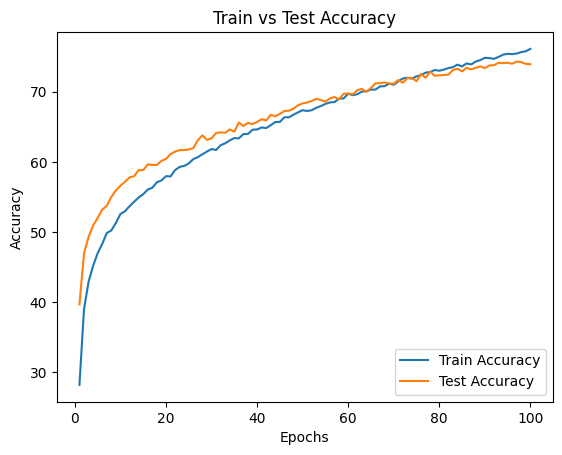

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
train_accs_gpu = train_accs.copy()
test_accs_gpu = test_accs.copy()
# train_accs_cpu = [acc.cpu().item() for acc in train_accs_gpu]
# test_accs_cpu = [acc.cpu().item() for acc in test_accs_gpu]
# print(train_accs)
# print(test_accs)
plt.plot(range(1, 101), train_accs_gpu, label='Train Accuracy')
plt.plot(range(1, 101), test_accs_gpu, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')

In [26]:
model.eval()

VisionTransformer(
  (patch_to_embed): Linear(in_features=48, out_features=128, bias=True)
  (transformer): Transformer(
    (trans_blocks): ModuleList(
      (0-5): 6 x TransformerBlock(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attention): Attention(
          (query): Linear(in_features=128, out_features=128, bias=True)
          (key): Linear(in_features=128, out_features=128, bias=True)
          (value): Linear(in_features=128, out_features=128, bias=True)
          (softmax): Softmax(dim=-1)
          (activation): Identity()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (feed_forward): FeedForward(
          (fc1): Linear(in_features=128, out_features=128, bias=True)
          (activation): GELU(approximate='none')
          (fc2): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
    

In [ ]:
import psutil
from thop import profile
def calculate_accuracy(model, dataloader):
    correct = total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            # print(images.shape)
            outputs,_ = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# --- 2. Inference Speed and Latency ---
def benchmark_inference(model, input_shape=(1, 3, 32, 32), runs=100):
    dummy_input = torch.randn(input_shape).to(device)
    torch.cuda.synchronize()
    start = time.time()
    for i in range(runs):
        output,_ = model(dummy_input)
    torch.cuda.synchronize()
    total_time = time.time() - start
    latency = total_time / runs
    throughput = runs / total_time
    return latency, throughput

# --- 3. Model Size ---
def get_model_size(model, temp_path='temp.pth'):
    torch.save(model.state_dict(), temp_path)
    size_mb = os.path.getsize(temp_path) / 1e6
    os.remove(temp_path)
    return size_mb

# --- 4. Memory Usage (estimated by RAM during execution) ---
def get_memory_usage():
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / 1e6  # in MB
    return mem

# --- 5. FLOPs and Parameters ---
def get_flops(model, input_shape=(1, 3, 32, 32)):
    dummy_input = torch.randn(input_shape).to(device)
    flops, params = profile(model, inputs=(dummy_input,), verbose=False)
    return flops / 1e9, params / 1e6  # GFLOPs and MParams

# --- 6. Estimate Power Usage ---
def estimate_power(flops, latency):
    # Rough estimate: 1 GFLOP = ~0.1 Watt-sec (example heuristic)
    energy = flops * 0.1  # Watt-seconds
    power = energy / latency  # Watts
    return power

# --- Run all metrics ---
accuracy = calculate_accuracy(model, testloader)
latency, speed = benchmark_inference(model)
model_size = get_model_size(model)
mem_usage = get_memory_usage()
flops, params = get_flops(model)
power = estimate_power(flops, latency)

# --- Print results ---
print(f"Accuracy: {accuracy:.4f}")
print(f"Inference Latency: {latency*1000:.2f} ms")
print(f"Inference Speed: {speed:.2f} samples/sec")
print(f"Model Size: {model_size:.2f} MB")
print(f"Memory Usage (runtime): {mem_usage:.2f} MB")
print(f"FLOPs: {flops:.2f} GFLOPs")
print(f"Parameters: {params:.2f} Million")
print(f"Estimated Power: {power:.2f} Watts")

In [ ]:
# Accuracy: 0.6880
# Inference Latency: 1.36 ms
# Inference Speed: 732.69 samples/sec
# Model Size: 2.14 MB
# Memory Usage (runtime): 1487.27 MB
# FLOPs: 0.03 GFLOPs
# Parameters: 0.51 Million
# Estimated Power: 2.44 Watts

In [20]:
model.transformer.trans_blocks

ModuleList(
  (0-5): 6 x TransformerBlock(
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (attention): Attention(
      (query): Linear(in_features=128, out_features=128, bias=True)
      (key): Linear(in_features=128, out_features=128, bias=True)
      (value): Linear(in_features=128, out_features=128, bias=True)
      (softmax): Softmax(dim=-1)
      (activation): Identity()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (feed_forward): FeedForward(
      (fc1): Linear(in_features=128, out_features=128, bias=True)
      (activation): GELU(approximate='none')
      (fc2): Linear(in_features=128, out_features=128, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)

In [21]:
model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads)

In [22]:
checkpoint = torch.load('./baseline_vit_checkpoint/VIT_CIFAR10_checkpoint_epoch_final.pt', map_location='cuda' if torch.cuda.is_available() else 'cpu')

model.load_state_dict(checkpoint['model'])
model.eval().to(device)

VisionTransformer(
  (patch_to_embed): Linear(in_features=48, out_features=128, bias=True)
  (transformer): Transformer(
    (trans_blocks): ModuleList(
      (0-5): 6 x TransformerBlock(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attention): Attention(
          (query): Linear(in_features=128, out_features=128, bias=True)
          (key): Linear(in_features=128, out_features=128, bias=True)
          (value): Linear(in_features=128, out_features=128, bias=True)
          (softmax): Softmax(dim=-1)
          (activation): Identity()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (feed_forward): FeedForward(
          (fc1): Linear(in_features=128, out_features=128, bias=True)
          (activation): GELU(approximate='none')
          (fc2): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
    

In [26]:
import time
import os

In [27]:
# --- Run all metrics ---
accuracy = calculate_accuracy(model, testloader)
latency, speed = benchmark_inference(model)
model_size = get_model_size(model)
mem_usage = get_memory_usage()
flops, params = get_flops(model)
power = estimate_power(flops, latency)

# --- Print results ---
print(f"Accuracy: {accuracy:.4f}")
print(f"Inference Latency: {latency*1000:.2f} ms")
print(f"Inference Speed: {speed:.2f} samples/sec")
print(f"Model Size: {model_size:.2f} MB")
print(f"Memory Usage (runtime): {mem_usage:.2f} MB")
print(f"FLOPs: {flops:.2f} GFLOPs")
print(f"Parameters: {params:.2f} Million")
print(f"Estimated Power: {power:.2f} Watts")

Accuracy: 0.7394
Inference Latency: 1.67 ms
Inference Speed: 599.15 samples/sec
Model Size: 2.12 MB
Memory Usage (runtime): 1128.40 MB
FLOPs: 0.03 GFLOPs
Parameters: 0.51 Million
Estimated Power: 2.00 Watts


In [166]:
loaded_model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads)

In [167]:
# checkpoint.keys()

In [168]:
checkpoint = torch.load('./baseline_vit_checkpoint/VIT_CIFAR10_checkpoint_epoch_final.pt', map_location='cuda' if torch.cuda.is_available() else 'cpu')

loaded_model.load_state_dict(checkpoint['model'])
loaded_model.eval().to(device)

VisionTransformer(
  (patch_to_embed): Linear(in_features=48, out_features=128, bias=True)
  (transformer): Transformer(
    (trans_blocks): ModuleList(
      (0-5): 6 x TransformerBlock(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attention): Attention(
          (query): Linear(in_features=128, out_features=128, bias=True)
          (key): Linear(in_features=128, out_features=128, bias=True)
          (value): Linear(in_features=128, out_features=128, bias=True)
          (softmax): Softmax(dim=-1)
          (activation): Identity()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (feed_forward): FeedForward(
          (fc1): Linear(in_features=128, out_features=128, bias=True)
          (activation): GELU(approximate='none')
          (fc2): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
    

In [169]:
import torch.nn.utils.prune as prune
def prune_mlp_neurons(model, ratio=0.4):
    for block in model.transformer.trans_blocks:
        for layer in [block.feed_forward.fc1, block.feed_forward.fc2]:
            prune.ln_structured(layer, name='weight', amount=ratio, n=1, dim=0)
            prune.remove(layer, 'weight')
    print(f"🔧 Pruned {int(ratio*100)}% of MLP neurons in fc1 and fc2.")

In [170]:
def prune_attention_heads(model, num_heads=6, keep_heads=[0, 1, 2, 3]):
    for block in model.transformer.trans_blocks:
        for proj_name in ['query', 'key', 'value']:
            proj = getattr(block.attention, proj_name)
            w = proj.weight.data
            b = proj.bias.data if proj.bias is not None else None

            head_dim = w.shape[0] // num_heads
            kept_indices = []
            for h in keep_heads:
                kept_indices.extend(range(h * head_dim, (h + 1) * head_dim))
            w_pruned = w[kept_indices, :]
            proj.weight = torch.nn.Parameter(w_pruned)

            if b is not None:
                b_pruned = b[kept_indices]
                proj.bias = torch.nn.Parameter(b_pruned)
    print(f"🔧 Kept attention heads: {keep_heads}")

In [171]:
def prune_transformer_blocks(model, keep_ratio=0.8):
    blocks = model.transformer.trans_blocks
    scores = []
    for block in blocks:
        score = torch.norm(block.feed_forward.fc1.weight, p=2).item() + \
                torch.norm(block.attention.query.weight, p=2).item()
        scores.append(score)

    keep_count = int(len(blocks) * keep_ratio)
    topk_idx = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:keep_count]
    new_blocks = [block for i, block in enumerate(blocks) if i in topk_idx]
    model.transformer.trans_blocks = torch.nn.ModuleList(new_blocks)

    print(f"🔧 Kept top {keep_count}/{len(blocks)} Transformer blocks (based on norm).")


In [172]:
prune_mlp_neurons(loaded_model, ratio=0.3)

🔧 Pruned 30% of MLP neurons in fc1 and fc2.


In [173]:
#prune_transformer_blocks(loaded_model, keep_ratio=0.8)

In [174]:
print(calculate_accuracy(loaded_model, testloader))

0.688


In [177]:
# --- Run all metrics ---
accuracy = calculate_accuracy(loaded_model, testloader)
latency, speed = benchmark_inference(loaded_model)
model_size = get_model_size(loaded_model)
mem_usage = get_memory_usage()
flops, params = get_flops(loaded_model)
power = estimate_power(flops, latency)

# --- Print results ---
print(f"Accuracy: {accuracy:.4f}")
print(f"Inference Latency: {latency*1000:.2f} ms")
print(f"Inference Speed: {speed:.2f} samples/sec")
print(f"Model Size: {model_size:.2f} MB")
print(f"Memory Usage (runtime): {mem_usage:.2f} MB")
print(f"FLOPs: {flops:.2f} GFLOPs")
print(f"Parameters: {params:.2f} Million")
print(f"Estimated Power: {power:.2f} Watts")

Accuracy: 0.6880
Inference Latency: 1.35 ms
Inference Speed: 741.93 samples/sec
Model Size: 2.14 MB
Memory Usage (runtime): 1492.16 MB
FLOPs: 0.03 GFLOPs
Parameters: 0.51 Million
Estimated Power: 2.47 Watts
